In [ ]:
!pip install CoolProp
!pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import CoolProp.CoolProp as CP
import numpy as np
import pyswarms as ps

# Parâmetros do sistema de refrigeração
refri1 = 'R404A'  # Ciclo superior
refri2 = 'R134a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo 1 (50°C)
efi = 0.7

# Restrições para as variáveis de otimização
Psep_min = 106399  # Psep1 deve ser maior que 106399
Psep_max = 1050000 # Psep1 deve ser menor que P6

P6_min = Psep_min # P6 deve ser maior que Psep1
P6_max = 1050000  # P6 deve ser menor que 1100000

Psep2_min = 202232  # Psep2 deve ser maior que 202232
Psep2_max = 2310870  # Psep2 deve ser menor que 2310870


# Função para calcular COP
def calcular_COP(Psep, P6, Psep2):
    try:
        # Ponto 1
        Temperatura_1 = -25 + 273.15  # -25°C
        h_1 = CP.PropsSI('H', 'T', Temperatura_1, 'Q', 1, refri2)
        s_1 = CP.PropsSI('S', 'T', Temperatura_1, 'Q', 1, refri2)
        P_1 = CP.PropsSI('P', 'T', Temperatura_1, 'Q', 1, refri2)
        # Ponto 2
        h_2s = CP.PropsSI('H', 'P', Psep, 'S', s_1, refri2)
        h_2 = ((h_2s-h_1)/efi) + h_1
        # Ponto 3
        h_3 = CP.PropsSI('H', 'P', Psep, 'Q', 0, refri2)
        # Ponto 4
        h_4 = h_3
        # Ponto 5
        h_5 = CP.PropsSI('H', 'P', Psep, 'Q', 1, refri2)
        s_5 = CP.PropsSI('S', 'P', Psep, 'Q', 1, refri2)
        # Ponto 6
        h_6s = CP.PropsSI('H', 'P', P6, 'S', s_5, refri2)
        h_6 = ((h_6s-h_5)/efi) + h_5
        s_6 = CP.PropsSI('S', 'P', P6, 'H', h_6, refri2)
        Temperatura_6 = CP.PropsSI('T', 'P', P6, 'H', h_6, refri2)
        # Ponto 7
        h_7 = CP.PropsSI('H', 'P', P6, 'Q', 0, refri2)
        s_7 = CP.PropsSI('S', 'P', P6, 'Q', 0, refri2)
        Temperatura_7 = CP.PropsSI('T', 'P', P6, 'Q', 0, refri2)
        # Ponto 8
        h_8 = h_7
        # Ponto 9
        Temperatura_9 = Temperatura_7 - delta_T
        h_9 = CP.PropsSI('H', 'T', Temperatura_9, 'Q', 1, refri1)
        s_9 = CP.PropsSI('S', 'T', Temperatura_9, 'Q', 1, refri1)
        P_9 = CP.PropsSI('P', 'T', Temperatura_9, 'Q', 1, refri1)
        # Ponto 10
        s_10s = s_9
        h_10s = CP.PropsSI('H', 'S', s_10s, 'P', Psep2, refri1)
        h_10 = ((h_10s-h_9)/efi) + h_9
        # Ponto 11
        h_11 = CP.PropsSI('H', 'P', Psep2, 'Q', 0, refri1)
        # Ponto 12
        h_12 = h_11
        Temperatura_12 = CP.PropsSI('T', 'P', P_9, 'H', h_12, refri1)
        # Ponto 13
        h_13 = CP.PropsSI('H', 'P', Psep2, 'Q', 1, refri1)
        s_13 = CP.PropsSI('S', 'P', Psep2, 'Q', 1, refri1)
        # Ponto 15
        h_15 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
        P_15 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
        # Ponto 14
        P_14 = P_15
        h_14s = CP.PropsSI('H','P', P_14, 'S', s_13, refri1)
        h_14 = ((h_14s-h_13)/efi) + h_13
        # Ponto 16
        h_16 = h_15

        # Cálculo das vazões mássicas e do trabalho
        m1 = carga_termica / (h_1 - h_4)
        m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))
        m3 = m2 * ((h_7 - h_6) / (h_12 - h_9))
        m4 = m3 * ((h_11 - h_10) / (h_16 - h_13))
        w1 = m1 * (h_2 - h_1)
        w2 = m2 * (h_6 - h_5)
        w3 = m3 * (h_10 - h_9)
        w4 = m4 * (h_14 - h_13)

        # Cálculo do COP
        COP = carga_termica / (w1 + w2 + w3 + w4)
        return COP
    except:
        return -np.inf  # Penalidade para valores inválidos

# Função objetivo para o PSO
def funcao_objetivo(x):
    Psep, P6, Psep2 = x[:, 0], x[:, 1], x[:, 2]
    COP_valores = np.array([-calcular_COP(Psep[i], P6[i], Psep2[i]) for i in range(len(Psep))])
    return COP_valores

# Configuração do PSO
limites = (np.array([Psep_min, P6_min, Psep_min]), np.array([Psep_max, P6_max, Psep2_max]))
opcoes = {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
optimizer = ps.single.GlobalBestPSO(n_particles=15, dimensions=3, options=opcoes, bounds=limites)

# Execução do PSO
melhor_custo, melhor_posicao = optimizer.optimize(funcao_objetivo, iters=40)

# Resultados
Psep_otimizado, P6_otimizado, Psep2_otimizado = melhor_posicao
COP_otimizado = -melhor_custo

# Exibição dos resultados
print(f"Valores ótimos encontrados:")
print(f"P6 = {P6_otimizado :.2f} kPa")
print(f"Psep = {Psep_otimizado :.2f} kPa")
print(f"Psep2 = {Psep2_otimizado :.2f} kPa")
print(f"COP otimizado = {COP_otimizado:.4f}")

2025-02-22 15:00:20,644 - pyswarms.single.global_best - INFO - Optimize for 40 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|40/40, best_cost=-1.74
2025-02-22 15:00:25,616 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.7355261879884616, best pos: [ 332507.93167924  772050.53761414 1752447.87038204]


Valores ótimos encontrados:
P6 = 772050.54 kPa
Psep = 332507.93 kPa
Psep2 = 1752447.87 kPa
COP otimizado = 1.7355


In [ ]:
import numpy as np
import CoolProp.CoolProp as CP

# Valores fixados
refri1 = 'R123'  # Ciclo superior
refri2 = 'R600a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo 1 (50°C)
efi = 0.7
superaquecimento = 5  # Superaquecimento fixo em 5 °C
tl = -16+273.15
t0 = 30+273.15
P6 = 240070
Psep = 127090
Psep2 = 106230

# Dados do estado "0"
t0 = 30 + 273.15  # Temperatura ambiente em K
h0_2 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri2)
s0_2 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri2)
h0_1 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri1)
s0_1 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri1)

# Ponto 1
Temperatura_1 = -25 + 273.15  # -25°C
h_1 = CP.PropsSI('H', 'T', Temperatura_1, 'Q', 1, refri2)
s_1 = CP.PropsSI('S', 'T', Temperatura_1, 'Q', 1, refri2)
P_1 = CP.PropsSI('P', 'T', Temperatura_1, 'Q', 1, refri2)
af1 = (h_1 - h0_2) - (t0 * (s_1 - s0_2))
# Ponto 2
h_2s = CP.PropsSI('H', 'P', Psep, 'S', s_1, refri2)
h_2 = ((h_2s-h_1)/efi) + h_1
s_2 = CP.PropsSI('S', 'P', Psep, 'H', h_2, refri2)
af2 = (h_2 - h0_2) - (t0 * (s_2 - s0_2))
# Ponto 3
h_3 = CP.PropsSI('H', 'P', Psep, 'Q', 0, refri2)
s_3 = CP.PropsSI('S', 'P', Psep, 'Q', 0, refri2)
af3 = (h_3 - h0_2) - (t0 * (s_3 - s0_2))
# Ponto 4
h_4 = h_3
s_4 = CP.PropsSI('S', 'P', P_1, 'H', h_4, refri2)
af4 = (h_4 - h0_2) - (t0 * (s_4 - s0_2))
# Ponto 5
h_5 = CP.PropsSI('H', 'P', Psep, 'Q', 1, refri2)
s_5 = CP.PropsSI('S', 'P', Psep, 'Q', 1, refri2)
af5 = (h_5 - h0_2) - (t0 * (s_5 - s0_2))
# Ponto 6
h_6s = CP.PropsSI('H', 'P', P6, 'S', s_5, refri2)
h_6 = ((h_6s-h_5)/efi) + h_5
s_6 = CP.PropsSI('S', 'P', P6, 'H', h_6, refri2)
Temperatura_6 = CP.PropsSI('T', 'P', P6, 'H', h_6, refri2)
af6 = (h_6 - h0_2) - (t0 * (s_6 - s0_2))
# Ponto 7
h_7 = CP.PropsSI('H', 'P', P6, 'Q', 0, refri2)
s_7 = CP.PropsSI('S', 'P', P6, 'Q', 0, refri2)
Temperatura_7 = CP.PropsSI('T', 'P', P6, 'Q', 0, refri2)
af7 = (h_7 - h0_2) - (t0 * (s_7 - s0_2))
# Ponto 8
h_8 = h_7
s_8 = CP.PropsSI('S', 'P', Psep, 'H', h_8, refri2)
af8 = (h_8 - h0_2) - (t0 * (s_8 - s0_2))
# Ponto 9
Temperatura_9 = Temperatura_7 - delta_T
h_9 = CP.PropsSI('H', 'T', Temperatura_9, 'Q', 1, refri1)
s_9 = CP.PropsSI('S', 'T', Temperatura_9, 'Q', 1, refri1)
P_9 = CP.PropsSI('P', 'T', Temperatura_9, 'Q', 1, refri1)
af9 = (h_9 - h0_1) - (t0 * (s_9 - s0_1))
# Ponto 10
s_10s = s_9
h_10s = CP.PropsSI('H', 'S', s_10s, 'P', Psep2, refri1)
h_10 = ((h_10s-h_9)/efi) + h_9
s_10 = CP.PropsSI('S', 'P', Psep2, 'H', h_10, refri1)
af10 = (h_10 - h0_1) - (t0 * (s_10 - s0_1))
# Ponto 11
h_11 = CP.PropsSI('H', 'P', Psep2, 'Q', 0, refri1)
s_11 = CP.PropsSI('S', 'P', Psep2, 'Q', 0, refri1)
af11 = (h_11 - h0_1) - (t0 * (s_11 - s0_1))
# Ponto 12
h_12 = h_11
Temperatura_12 = CP.PropsSI('T', 'P', P_9, 'H', h_12, refri1)
s_12 = CP.PropsSI('S', 'P', P_9, 'H', h_12, refri1)
af12 = (h_12 - h0_1) - (t0 * (s_12 - s0_1))
# Ponto 13
h_13 = CP.PropsSI('H', 'P', Psep2, 'Q', 1, refri1)
s_13 = CP.PropsSI('S', 'P', Psep2, 'Q', 1, refri1)
af13 = (h_13 - h0_1) - (t0 * (s_13 - s0_1))
# Ponto 15
h_15 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
P_15 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
s_15 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)
af15 = (h_15 - h0_1) - (t0 * (s_15 - s0_1))
# Ponto 14
P_14 = P_15
h_14s = CP.PropsSI('H','P', P_14, 'S', s_13, refri1)
h_14 = ((h_14s-h_13)/efi) + h_13
s_14 = CP.PropsSI('S', 'P', P_14, 'H', h_14, refri1)
af14 = (h_14 - h0_1) - (t0 * (s_14 - s0_1))
# Ponto 16
h_16 = h_15
s_16 = CP.PropsSI('S', 'P', Psep2, 'H', h_16, refri1)
af16 = (h_16 - h0_1) - (t0 * (s_16 - s0_1))

# Cálculo das vazões mássicas e do trabalho
m1 = carga_termica / (h_1 - h_4)
m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))
m3 = m2 * ((h_7 - h_6) / (h_12 - h_9))
m4 = m3 * ((h_11 - h_10) / (h_16 - h_13))
w1 = m1 * (h_2 - h_1)
w2 = m2 * (h_6 - h_5)
w3 = m3 * (h_10 - h_9)
w4 = m4 * (h_14 - h_13)

# Cálculo da diferença de temperatura média logarítmica (LMTD)
delta_T_m = (((Temperatura_6 - Temperatura_12) - (Temperatura_7 - Temperatura_9)) / np.log((Temperatura_6 - Temperatura_12) / (Temperatura_7 - Temperatura_9)))

# Cálculo de Q
Q = m3 * (h_9 - h_12)  # Calor trocado no ciclo superior

# Cálculo de UA
UA = Q / delta_T_m

# Cálculo do COP
COP = carga_termica / (w1 + w2 + w3 + w4)

# Destruição de exergia
ADComp1 = (m1*af1)+w1-(m1*af2)
ADSep1 = (m1*(af2-af3))+(m2*(af8-af5))
ADValv1 = m1*(af3-af4)
ADEvap = (m1*af4)+(carga_termica*(1-(t0/tl)))-(m1*af1)
ADComp2 = (m2*af5)+w2-(m2*af6)
ADValv2 = m2*(af7-af8)
ADTrocCasc = (m2*(af6-af7))+(m3*(af12-af9))
ADComp3 = (m3*af9)+w3-(m3*af10)
ADSep2 = (m3*(af10-af11))+(m4*(af16-af13))
ADValv3 = m3*(af11-af12)
ADComp4 = (m4*af13)+w4-(m4*af14)
ADCond = m4*(af14-af15)
ADValv4 = m4*(af15-af16)

# Informações do ciclo
ADTotal = (w1+w2+w3+w4)+(carga_termica*(1-(t0/tl)))
th = t0
COPteorico = tl / (th - tl)
N2 = COP / COPteorico

print(round(ADComp1,2))
print(round(ADSep1,2))
print(round(ADValv1,2))
print(round(ADEvap,2))
print(round(ADComp2,2))
print(round(ADTrocCasc,2))
print(round(ADValv2,2))
print(round(ADComp3,2))
print(round(ADSep2,2))
print(round(ADValv3,2))
print(round(ADComp4,2))
print(round(ADValv4,2))
print(round(ADCond,2))

print(COP)
print(round(ADTotal,2))
print(ADComp1+ADSep1+ADValv1+ADEvap+ADComp2+ADTrocCasc+ADValv2+ADComp3+ADSep2+ADValv3+ADComp4+ADValv4+ADCond)


78.95
1.52
12.28
85.51
74.95
47.34
12.79
86.54
1.09
14.28
82.7
14.83
189.8
1.8861999884268124
702.57
702.5651112682606


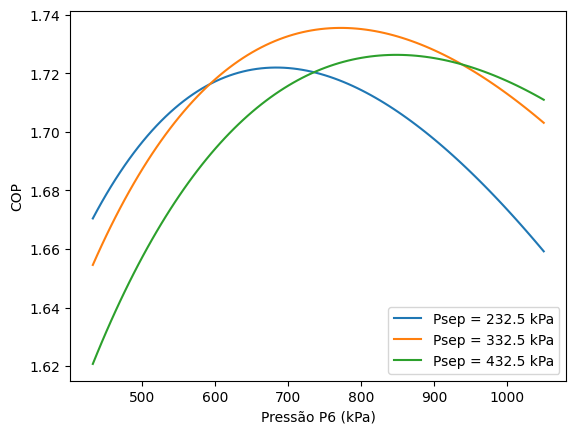

In [ ]:
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import numpy as np

# Valores fixados
refri1 = 'R404A'  # Ciclo superior
refri2 = 'R134a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo 1 (50°C)
efi = 0.7
Psep2 = 1752460

# Valores de Psep para as isolinhas em Pa
valores_de_Psep = [232500, 332500, 432500]

# Intervalo de valores de P6 para o gráfico em Pa
valores_de_P6 = np.linspace(432500, 1050000, 100)

# Loop sobre os valores de Psep (para as isolinhas)
for Psep in valores_de_Psep:
    valores_COP = []
    pressoes_p6 = []

    # Loop para diferentes valores de P6
    for P6 in valores_de_P6:
        # Dados do estado "0"
        t0 = 30 + 273.15  # Temperatura ambiente em K
        h0_2 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri2)
        s0_2 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri2)
        h0_1 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri1)
        s0_1 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri1)

        # Ponto 1
        Temperatura_1 = -25 + 273.15  # -25°C
        h_1 = CP.PropsSI('H', 'T', Temperatura_1, 'Q', 1, refri2)
        s_1 = CP.PropsSI('S', 'T', Temperatura_1, 'Q', 1, refri2)
        P_1 = CP.PropsSI('P', 'T', Temperatura_1, 'Q', 1, refri2)
        af1 = (h_1 - h0_2) - (t0 * (s_1 - s0_2))
        # Ponto 2
        h_2s = CP.PropsSI('H', 'P', Psep, 'S', s_1, refri2)
        h_2 = ((h_2s-h_1)/efi) + h_1
        s_2 = CP.PropsSI('S', 'P', Psep, 'H', h_2, refri2)
        af2 = (h_2 - h0_2) - (t0 * (s_2 - s0_2))
        # Ponto 3
        h_3 = CP.PropsSI('H', 'P', Psep, 'Q', 0, refri2)
        s_3 = CP.PropsSI('S', 'P', Psep, 'Q', 0, refri2)
        af3 = (h_3 - h0_2) - (t0 * (s_3 - s0_2))
        # Ponto 4
        h_4 = h_3
        s_4 = CP.PropsSI('S', 'P', P_1, 'H', h_4, refri2)
        af4 = (h_4 - h0_2) - (t0 * (s_4 - s0_2))
        # Ponto 5
        h_5 = CP.PropsSI('H', 'P', Psep, 'Q', 1, refri2)
        s_5 = CP.PropsSI('S', 'P', Psep, 'Q', 1, refri2)
        af5 = (h_5 - h0_2) - (t0 * (s_5 - s0_2))
        # Ponto 6
        h_6s = CP.PropsSI('H', 'P', P6, 'S', s_5, refri2)
        h_6 = ((h_6s-h_5)/efi) + h_5
        s_6 = CP.PropsSI('S', 'P', P6, 'H', h_6, refri2)
        Temperatura_6 = CP.PropsSI('T', 'P', P6, 'H', h_6, refri2)
        af6 = (h_6 - h0_2) - (t0 * (s_6 - s0_2))
        # Ponto 7
        h_7 = CP.PropsSI('H', 'P', P6, 'Q', 0, refri2)
        s_7 = CP.PropsSI('S', 'P', P6, 'Q', 0, refri2)
        Temperatura_7 = CP.PropsSI('T', 'P', P6, 'Q', 0, refri2)
        af7 = (h_7 - h0_2) - (t0 * (s_7 - s0_2))
        # Ponto 8
        h_8 = h_7
        s_8 = CP.PropsSI('S', 'P', Psep, 'H', h_8, refri2)
        af8 = (h_8 - h0_2) - (t0 * (s_8 - s0_2))
        # Ponto 9
        Temperatura_9 = Temperatura_7 - delta_T
        h_9 = CP.PropsSI('H', 'T', Temperatura_9, 'Q', 1, refri1)
        s_9 = CP.PropsSI('S', 'T', Temperatura_9, 'Q', 1, refri1)
        P_9 = CP.PropsSI('P', 'T', Temperatura_9, 'Q', 1, refri1)
        af9 = (h_9 - h0_1) - (t0 * (s_9 - s0_1))
        # Ponto 10
        s_10s = s_9
        h_10s = CP.PropsSI('H', 'S', s_10s, 'P', Psep2, refri1)
        h_10 = ((h_10s-h_9)/efi) + h_9
        s_10 = CP.PropsSI('S', 'P', Psep2, 'H', h_10, refri1)
        af10 = (h_10 - h0_1) - (t0 * (s_10 - s0_1))
        # Ponto 11
        h_11 = CP.PropsSI('H', 'P', Psep2, 'Q', 0, refri1)
        s_11 = CP.PropsSI('S', 'P', Psep2, 'Q', 0, refri1)
        af11 = (h_11 - h0_1) - (t0 * (s_11 - s0_1))
        # Ponto 12
        h_12 = h_11
        Temperatura_12 = CP.PropsSI('T', 'P', P_9, 'H', h_12, refri1)
        s_12 = CP.PropsSI('S', 'P', P_9, 'H', h_12, refri1)
        af12 = (h_12 - h0_1) - (t0 * (s_12 - s0_1))
        # Ponto 13
        h_13 = CP.PropsSI('H', 'P', Psep2, 'Q', 1, refri1)
        s_13 = CP.PropsSI('S', 'P', Psep2, 'Q', 1, refri1)
        af13 = (h_13 - h0_1) - (t0 * (s_13 - s0_1))
        # Ponto 15
        h_15 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
        P_15 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
        s_15 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)
        af15 = (h_15 - h0_1) - (t0 * (s_15 - s0_1))
        # Ponto 14
        P_14 = P_15
        h_14s = CP.PropsSI('H','P', P_14, 'S', s_13, refri1)
        h_14 = ((h_14s-h_13)/efi) + h_13
        s_14 = CP.PropsSI('S', 'P', P_14, 'H', h_14, refri1)
        af14 = (h_14 - h0_1) - (t0 * (s_14 - s0_1))
        # Ponto 16
        h_16 = h_15
        s_16 = CP.PropsSI('S', 'P', Psep2, 'H', h_16, refri1)
        af16 = (h_16 - h0_1) - (t0 * (s_16 - s0_1))

        # Cálculo das vazões mássicas e do trabalho
        m1 = carga_termica / (h_1 - h_4)
        m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))
        m3 = m2 * ((h_7 - h_6) / (h_12 - h_9))
        m4 = m3 * ((h_11 - h_10) / (h_16 - h_13))
        w1 = m1 * (h_2 - h_1)
        w2 = m2 * (h_6 - h_5)
        w3 = m3 * (h_10 - h_9)
        w4 = m4 * (h_14 - h_13)

        # Cálculo da diferença de temperatura média logarítmica (LMTD)
        delta_T_m = (((Temperatura_6 - Temperatura_12) - (Temperatura_7 - Temperatura_9)) / np.log((Temperatura_6 - Temperatura_12) / (Temperatura_7 - Temperatura_9)))

        # Cálculo de Q
        Q = m3*(h_9-h_12)
        # Cálculo de UA
        UA = Q / delta_T_m

        # Cálculo do COP
        COP = carga_termica / (w1 + w2 + w3 + w4)

        # Armazenar os resultados para plotagem
        valores_COP.append(COP)
        pressoes_p6.append(P6 / 1e3)  # Convertendo P6 para kPa

    # Plotar o gráfico UA x P6 para cada valor de Psep
    plt.plot(pressoes_p6, valores_COP, label=f'Psep = {Psep / 1e3} kPa')

# Configurações do gráfico
plt.xlabel('Pressão P6 (kPa)')
plt.ylabel('COP')
plt.legend()
plt.grid(False)
plt.show()

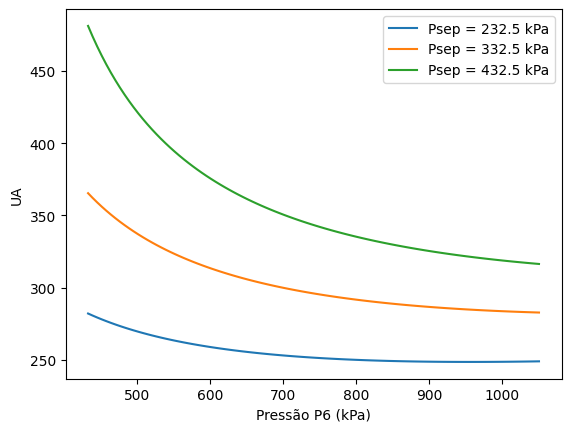

In [ ]:
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import numpy as np

# Valores fixados
refri1 = 'R404A'  # Ciclo superior
refri2 = 'R134a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo 1 (50°C)
efi = 0.7
tl = -16+273.15
Psep2 = 1752460

# Valores de Psep para as isolinhas em Pa
valores_de_Psep = [232500, 332500, 432500]

# Intervalo de valores de P6 para o gráfico em Pa
valores_de_P6 = np.linspace(432500, 1050000, 100)

# Loop sobre os valores de Psep (para as isolinhas)
for Psep in valores_de_Psep:
    valores_UA = []
    pressoes_p6 = []

    # Loop para diferentes valores de P6
    for P6 in valores_de_P6:
        # Dados do estado "0"
        t0 = 30 + 273.15  # Temperatura ambiente em K
        h0_2 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri2)
        s0_2 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri2)
        h0_1 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri1)
        s0_1 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri1)

        # Ponto 1
        Temperatura_1 = -25 + 273.15  # -25°C
        h_1 = CP.PropsSI('H', 'T', Temperatura_1, 'Q', 1, refri2)
        s_1 = CP.PropsSI('S', 'T', Temperatura_1, 'Q', 1, refri2)
        P_1 = CP.PropsSI('P', 'T', Temperatura_1, 'Q', 1, refri2)
        af1 = (h_1 - h0_2) - (t0 * (s_1 - s0_2))
        # Ponto 2
        h_2s = CP.PropsSI('H', 'P', Psep, 'S', s_1, refri2)
        h_2 = ((h_2s-h_1)/efi) + h_1
        s_2 = CP.PropsSI('S', 'P', Psep, 'H', h_2, refri2)
        af2 = (h_2 - h0_2) - (t0 * (s_2 - s0_2))
        # Ponto 3
        h_3 = CP.PropsSI('H', 'P', Psep, 'Q', 0, refri2)
        s_3 = CP.PropsSI('S', 'P', Psep, 'Q', 0, refri2)
        af3 = (h_3 - h0_2) - (t0 * (s_3 - s0_2))
        # Ponto 4
        h_4 = h_3
        s_4 = CP.PropsSI('S', 'P', P_1, 'H', h_4, refri2)
        af4 = (h_4 - h0_2) - (t0 * (s_4 - s0_2))
        # Ponto 5
        h_5 = CP.PropsSI('H', 'P', Psep, 'Q', 1, refri2)
        s_5 = CP.PropsSI('S', 'P', Psep, 'Q', 1, refri2)
        af5 = (h_5 - h0_2) - (t0 * (s_5 - s0_2))
        # Ponto 6
        h_6s = CP.PropsSI('H', 'P', P6, 'S', s_5, refri2)
        h_6 = ((h_6s-h_5)/efi) + h_5
        s_6 = CP.PropsSI('S', 'P', P6, 'H', h_6, refri2)
        Temperatura_6 = CP.PropsSI('T', 'P', P6, 'H', h_6, refri2)
        af6 = (h_6 - h0_2) - (t0 * (s_6 - s0_2))
        # Ponto 7
        h_7 = CP.PropsSI('H', 'P', P6, 'Q', 0, refri2)
        s_7 = CP.PropsSI('S', 'P', P6, 'Q', 0, refri2)
        Temperatura_7 = CP.PropsSI('T', 'P', P6, 'Q', 0, refri2)
        af7 = (h_7 - h0_2) - (t0 * (s_7 - s0_2))
        # Ponto 8
        h_8 = h_7
        s_8 = CP.PropsSI('S', 'P', Psep, 'H', h_8, refri2)
        af8 = (h_8 - h0_2) - (t0 * (s_8 - s0_2))
        # Ponto 9
        Temperatura_9 = Temperatura_7 - delta_T
        h_9 = CP.PropsSI('H', 'T', Temperatura_9, 'Q', 1, refri1)
        s_9 = CP.PropsSI('S', 'T', Temperatura_9, 'Q', 1, refri1)
        P_9 = CP.PropsSI('P', 'T', Temperatura_9, 'Q', 1, refri1)
        af9 = (h_9 - h0_1) - (t0 * (s_9 - s0_1))
        # Ponto 10
        s_10s = s_9
        h_10s = CP.PropsSI('H', 'S', s_10s, 'P', Psep2, refri1)
        h_10 = ((h_10s-h_9)/efi) + h_9
        s_10 = CP.PropsSI('S', 'P', Psep2, 'H', h_10, refri1)
        af10 = (h_10 - h0_1) - (t0 * (s_10 - s0_1))
        # Ponto 11
        h_11 = CP.PropsSI('H', 'P', Psep2, 'Q', 0, refri1)
        s_11 = CP.PropsSI('S', 'P', Psep2, 'Q', 0, refri1)
        af11 = (h_11 - h0_1) - (t0 * (s_11 - s0_1))
        # Ponto 12
        h_12 = h_11
        Temperatura_12 = CP.PropsSI('T', 'P', P_9, 'H', h_12, refri1)
        s_12 = CP.PropsSI('S', 'P', P_9, 'H', h_12, refri1)
        af12 = (h_12 - h0_1) - (t0 * (s_12 - s0_1))
        # Ponto 13
        h_13 = CP.PropsSI('H', 'P', Psep2, 'Q', 1, refri1)
        s_13 = CP.PropsSI('S', 'P', Psep2, 'Q', 1, refri1)
        af13 = (h_13 - h0_1) - (t0 * (s_13 - s0_1))
        # Ponto 15
        h_15 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
        P_15 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
        s_15 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)
        af15 = (h_15 - h0_1) - (t0 * (s_15 - s0_1))
        # Ponto 14
        P_14 = P_15
        h_14s = CP.PropsSI('H','P', P_14, 'S', s_13, refri1)
        h_14 = ((h_14s-h_13)/efi) + h_13
        s_14 = CP.PropsSI('S', 'P', P_14, 'H', h_14, refri1)
        af14 = (h_14 - h0_1) - (t0 * (s_14 - s0_1))
        # Ponto 16
        h_16 = h_15
        s_16 = CP.PropsSI('S', 'P', Psep2, 'H', h_16, refri1)
        af16 = (h_16 - h0_1) - (t0 * (s_16 - s0_1))

        # Cálculo das vazões mássicas e do trabalho
        m1 = carga_termica / (h_1 - h_4)
        m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))
        m3 = m2 * ((h_7 - h_6) / (h_12 - h_9))
        m4 = m3 * ((h_11 - h_10) / (h_16 - h_13))
        w1 = m1 * (h_2 - h_1)
        w2 = m2 * (h_6 - h_5)
        w3 = m3 * (h_10 - h_9)
        w4 = m4 * (h_14 - h_13)

        # Cálculo da diferença de temperatura média logarítmica (LMTD)
        delta_T_m = (((Temperatura_6 - Temperatura_12) - (Temperatura_7 - Temperatura_9)) / np.log((Temperatura_6 - Temperatura_12) / (Temperatura_7 - Temperatura_9)))

        # Cálculo de Q
        Q = m3 * (h_9 - h_12)  # Calor trocado no ciclo superior

        # Cálculo de UA
        UA = Q / delta_T_m

        # Cálculo do COP
        COP = carga_termica / (w1 + w2 + w3 + w4)

        # Armazenar os resultados para plotagem
        valores_UA.append(UA)
        pressoes_p6.append(P6 / 1e3)  # Convertendo P6 para kPa

    # Plotar o gráfico UA x P6 para cada valor de Psep
    plt.plot(pressoes_p6, valores_UA, label=f'Psep = {Psep / 1e3} kPa')

# Configurações do gráfico
plt.xlabel('Pressão P6 (kPa)')
plt.ylabel('UA')
plt.legend()
plt.grid(False)
plt.show()

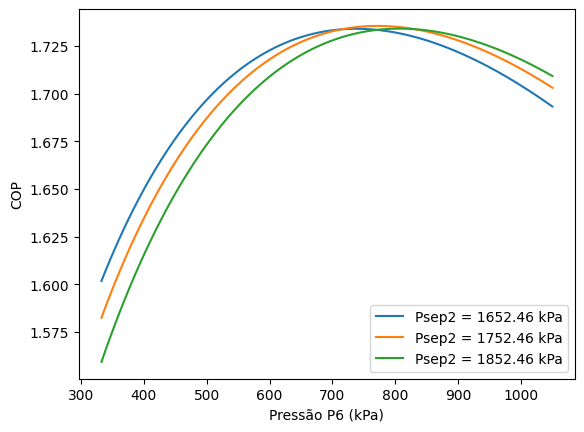

In [ ]:
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import numpy as np

# Valores fixados
refri1 = 'R404A'  # Ciclo superior
refri2 = 'R134a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo 1 (50°C)
efi = 0.7
Psep = 332500

# Valores de Psep para as isolinhas em Pa
valores_de_Psep2 = [1652460, 1752460, 1852460]

# Intervalo de valores de P6 para o gráfico em Pa
valores_de_P6 = np.linspace(332500, 1050000, 100)

# Loop sobre os valores de Psep (para as isolinhas)
for Psep2 in valores_de_Psep2:
    valores_COP = []
    pressoes_p6 = []

    # Loop para diferentes valores de P6
    for P6 in valores_de_P6:
        # Dados do estado "0"
        t0 = 30 + 273.15  # Temperatura ambiente em K
        h0_2 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri2)
        s0_2 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri2)
        h0_1 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri1)
        s0_1 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri1)

        # Ponto 1
        Temperatura_1 = -25 + 273.15  # -25°C
        h_1 = CP.PropsSI('H', 'T', Temperatura_1, 'Q', 1, refri2)
        s_1 = CP.PropsSI('S', 'T', Temperatura_1, 'Q', 1, refri2)
        P_1 = CP.PropsSI('P', 'T', Temperatura_1, 'Q', 1, refri2)
        af1 = (h_1 - h0_2) - (t0 * (s_1 - s0_2))
        # Ponto 2
        h_2s = CP.PropsSI('H', 'P', Psep, 'S', s_1, refri2)
        h_2 = ((h_2s-h_1)/efi) + h_1
        s_2 = CP.PropsSI('S', 'P', Psep, 'H', h_2, refri2)
        af2 = (h_2 - h0_2) - (t0 * (s_2 - s0_2))
        # Ponto 3
        h_3 = CP.PropsSI('H', 'P', Psep, 'Q', 0, refri2)
        s_3 = CP.PropsSI('S', 'P', Psep, 'Q', 0, refri2)
        af3 = (h_3 - h0_2) - (t0 * (s_3 - s0_2))
        # Ponto 4
        h_4 = h_3
        s_4 = CP.PropsSI('S', 'P', P_1, 'H', h_4, refri2)
        af4 = (h_4 - h0_2) - (t0 * (s_4 - s0_2))
        # Ponto 5
        h_5 = CP.PropsSI('H', 'P', Psep, 'Q', 1, refri2)
        s_5 = CP.PropsSI('S', 'P', Psep, 'Q', 1, refri2)
        af5 = (h_5 - h0_2) - (t0 * (s_5 - s0_2))
        # Ponto 6
        h_6s = CP.PropsSI('H', 'P', P6, 'S', s_5, refri2)
        h_6 = ((h_6s-h_5)/efi) + h_5
        s_6 = CP.PropsSI('S', 'P', P6, 'H', h_6, refri2)
        Temperatura_6 = CP.PropsSI('T', 'P', P6, 'H', h_6, refri2)
        af6 = (h_6 - h0_2) - (t0 * (s_6 - s0_2))
        # Ponto 7
        h_7 = CP.PropsSI('H', 'P', P6, 'Q', 0, refri2)
        s_7 = CP.PropsSI('S', 'P', P6, 'Q', 0, refri2)
        Temperatura_7 = CP.PropsSI('T', 'P', P6, 'Q', 0, refri2)
        af7 = (h_7 - h0_2) - (t0 * (s_7 - s0_2))
        # Ponto 8
        h_8 = h_7
        s_8 = CP.PropsSI('S', 'P', Psep, 'H', h_8, refri2)
        af8 = (h_8 - h0_2) - (t0 * (s_8 - s0_2))
        # Ponto 9
        Temperatura_9 = Temperatura_7 - delta_T
        h_9 = CP.PropsSI('H', 'T', Temperatura_9, 'Q', 1, refri1)
        s_9 = CP.PropsSI('S', 'T', Temperatura_9, 'Q', 1, refri1)
        P_9 = CP.PropsSI('P', 'T', Temperatura_9, 'Q', 1, refri1)
        af9 = (h_9 - h0_1) - (t0 * (s_9 - s0_1))
        # Ponto 10
        s_10s = s_9
        h_10s = CP.PropsSI('H', 'S', s_10s, 'P', Psep2, refri1)
        h_10 = ((h_10s-h_9)/efi) + h_9
        s_10 = CP.PropsSI('S', 'P', Psep2, 'H', h_10, refri1)
        af10 = (h_10 - h0_1) - (t0 * (s_10 - s0_1))
        # Ponto 11
        h_11 = CP.PropsSI('H', 'P', Psep2, 'Q', 0, refri1)
        s_11 = CP.PropsSI('S', 'P', Psep2, 'Q', 0, refri1)
        af11 = (h_11 - h0_1) - (t0 * (s_11 - s0_1))
        # Ponto 12
        h_12 = h_11
        Temperatura_12 = CP.PropsSI('T', 'P', P_9, 'H', h_12, refri1)
        s_12 = CP.PropsSI('S', 'P', P_9, 'H', h_12, refri1)
        af12 = (h_12 - h0_1) - (t0 * (s_12 - s0_1))
        # Ponto 13
        h_13 = CP.PropsSI('H', 'P', Psep2, 'Q', 1, refri1)
        s_13 = CP.PropsSI('S', 'P', Psep2, 'Q', 1, refri1)
        af13 = (h_13 - h0_1) - (t0 * (s_13 - s0_1))
        # Ponto 15
        h_15 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
        P_15 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
        s_15 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)
        af15 = (h_15 - h0_1) - (t0 * (s_15 - s0_1))
        # Ponto 14
        P_14 = P_15
        h_14s = CP.PropsSI('H','P', P_14, 'S', s_13, refri1)
        h_14 = ((h_14s-h_13)/efi) + h_13
        s_14 = CP.PropsSI('S', 'P', P_14, 'H', h_14, refri1)
        af14 = (h_14 - h0_1) - (t0 * (s_14 - s0_1))
        # Ponto 16
        h_16 = h_15
        s_16 = CP.PropsSI('S', 'P', Psep2, 'H', h_16, refri1)
        af16 = (h_16 - h0_1) - (t0 * (s_16 - s0_1))

        # Cálculo das vazões mássicas e do trabalho
        m1 = carga_termica / (h_1 - h_4)
        m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))
        m3 = m2 * ((h_7 - h_6) / (h_12 - h_9))
        m4 = m3 * ((h_11 - h_10) / (h_16 - h_13))
        w1 = m1 * (h_2 - h_1)
        w2 = m2 * (h_6 - h_5)
        w3 = m3 * (h_10 - h_9)
        w4 = m4 * (h_14 - h_13)

        # Cálculo da diferença de temperatura média logarítmica (LMTD)
        delta_T_m = (((Temperatura_6 - Temperatura_12) - (Temperatura_7 - Temperatura_9)) / np.log((Temperatura_6 - Temperatura_12) / (Temperatura_7 - Temperatura_9)))

        # Cálculo de Q
        Q = m3*(h_9-h_12)
        # Cálculo de UA
        UA = Q / delta_T_m

        # Cálculo do COP
        COP = carga_termica / (w1 + w2 + w3 + w4)

        # Armazenar os resultados para plotagem
        valores_COP.append(COP)
        pressoes_p6.append(P6 / 1e3)  # Convertendo P6 para kPa

    # Plotar o gráfico UA x P6 para cada valor de Psep
    plt.plot(pressoes_p6, valores_COP, label=f'Psep2 = {Psep2 / 1e3} kPa')

# Configurações do gráfico
plt.xlabel('Pressão P6 (kPa)')
plt.ylabel('COP')
plt.legend()
plt.grid(False)
plt.show()

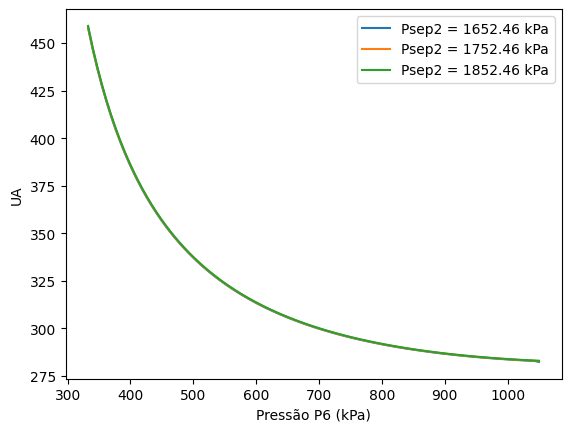

In [ ]:
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP
import numpy as np

# Valores fixados
refri1 = 'R404A'  # Ciclo superior
refri2 = 'R134a'  # Ciclo inferior
carga_termica = 2000  # Carga térmica em watts
delta_T = 5  # Diferença de temperatura no trocador
T_cond = 50 + 273.15  # Temperatura de condensação do ciclo 1 (50°C)
efi = 0.7
Psep = 332500

# Valores de Psep para as isolinhas em Pa
valores_de_Psep2 = [1652460, 1752460, 1852460]

# Intervalo de valores de P6 para o gráfico em Pa
valores_de_P6 = np.linspace(332500, 1050000, 100)

# Loop sobre os valores de Psep (para as isolinhas)
for Psep2 in valores_de_Psep2:
    valores_UA = []
    pressoes_p6 = []

    # Loop para diferentes valores de P6
    for P6 in valores_de_P6:
        # Dados do estado "0"
        t0 = 30 + 273.15  # Temperatura ambiente em K
        h0_2 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri2)
        s0_2 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri2)
        h0_1 = CP.PropsSI('H', 'T', t0, 'P', 101325, refri1)
        s0_1 = CP.PropsSI('S', 'T', t0, 'P', 101325, refri1)

        # Ponto 1
        Temperatura_1 = -25 + 273.15  # -25°C
        h_1 = CP.PropsSI('H', 'T', Temperatura_1, 'Q', 1, refri2)
        s_1 = CP.PropsSI('S', 'T', Temperatura_1, 'Q', 1, refri2)
        P_1 = CP.PropsSI('P', 'T', Temperatura_1, 'Q', 1, refri2)
        af1 = (h_1 - h0_2) - (t0 * (s_1 - s0_2))
        # Ponto 2
        h_2s = CP.PropsSI('H', 'P', Psep, 'S', s_1, refri2)
        h_2 = ((h_2s-h_1)/efi) + h_1
        s_2 = CP.PropsSI('S', 'P', Psep, 'H', h_2, refri2)
        af2 = (h_2 - h0_2) - (t0 * (s_2 - s0_2))
        # Ponto 3
        h_3 = CP.PropsSI('H', 'P', Psep, 'Q', 0, refri2)
        s_3 = CP.PropsSI('S', 'P', Psep, 'Q', 0, refri2)
        af3 = (h_3 - h0_2) - (t0 * (s_3 - s0_2))
        # Ponto 4
        h_4 = h_3
        s_4 = CP.PropsSI('S', 'P', P_1, 'H', h_4, refri2)
        af4 = (h_4 - h0_2) - (t0 * (s_4 - s0_2))
        # Ponto 5
        h_5 = CP.PropsSI('H', 'P', Psep, 'Q', 1, refri2)
        s_5 = CP.PropsSI('S', 'P', Psep, 'Q', 1, refri2)
        af5 = (h_5 - h0_2) - (t0 * (s_5 - s0_2))
        # Ponto 6
        h_6s = CP.PropsSI('H', 'P', P6, 'S', s_5, refri2)
        h_6 = ((h_6s-h_5)/efi) + h_5
        s_6 = CP.PropsSI('S', 'P', P6, 'H', h_6, refri2)
        Temperatura_6 = CP.PropsSI('T', 'P', P6, 'H', h_6, refri2)
        af6 = (h_6 - h0_2) - (t0 * (s_6 - s0_2))
        # Ponto 7
        h_7 = CP.PropsSI('H', 'P', P6, 'Q', 0, refri2)
        s_7 = CP.PropsSI('S', 'P', P6, 'Q', 0, refri2)
        Temperatura_7 = CP.PropsSI('T', 'P', P6, 'Q', 0, refri2)
        af7 = (h_7 - h0_2) - (t0 * (s_7 - s0_2))
        # Ponto 8
        h_8 = h_7
        s_8 = CP.PropsSI('S', 'P', Psep, 'H', h_8, refri2)
        af8 = (h_8 - h0_2) - (t0 * (s_8 - s0_2))
        # Ponto 9
        Temperatura_9 = Temperatura_7 - delta_T
        h_9 = CP.PropsSI('H', 'T', Temperatura_9, 'Q', 1, refri1)
        s_9 = CP.PropsSI('S', 'T', Temperatura_9, 'Q', 1, refri1)
        P_9 = CP.PropsSI('P', 'T', Temperatura_9, 'Q', 1, refri1)
        af9 = (h_9 - h0_1) - (t0 * (s_9 - s0_1))
        # Ponto 10
        s_10s = s_9
        h_10s = CP.PropsSI('H', 'S', s_10s, 'P', Psep2, refri1)
        h_10 = ((h_10s-h_9)/efi) + h_9
        s_10 = CP.PropsSI('S', 'P', Psep2, 'H', h_10, refri1)
        af10 = (h_10 - h0_1) - (t0 * (s_10 - s0_1))
        # Ponto 11
        h_11 = CP.PropsSI('H', 'P', Psep2, 'Q', 0, refri1)
        s_11 = CP.PropsSI('S', 'P', Psep2, 'Q', 0, refri1)
        af11 = (h_11 - h0_1) - (t0 * (s_11 - s0_1))
        # Ponto 12
        h_12 = h_11
        Temperatura_12 = CP.PropsSI('T', 'P', P_9, 'H', h_12, refri1)
        s_12 = CP.PropsSI('S', 'P', P_9, 'H', h_12, refri1)
        af12 = (h_12 - h0_1) - (t0 * (s_12 - s0_1))
        # Ponto 13
        h_13 = CP.PropsSI('H', 'P', Psep2, 'Q', 1, refri1)
        s_13 = CP.PropsSI('S', 'P', Psep2, 'Q', 1, refri1)
        af13 = (h_13 - h0_1) - (t0 * (s_13 - s0_1))
        # Ponto 15
        h_15 = CP.PropsSI('H', 'T', T_cond, 'Q', 0, refri1)
        P_15 = CP.PropsSI('P', 'T', T_cond, 'Q', 0, refri1)
        s_15 = CP.PropsSI('S', 'T', T_cond, 'Q', 0, refri1)
        af15 = (h_15 - h0_1) - (t0 * (s_15 - s0_1))
        # Ponto 14
        P_14 = P_15
        h_14s = CP.PropsSI('H','P', P_14, 'S', s_13, refri1)
        h_14 = ((h_14s-h_13)/efi) + h_13
        s_14 = CP.PropsSI('S', 'P', P_14, 'H', h_14, refri1)
        af14 = (h_14 - h0_1) - (t0 * (s_14 - s0_1))
        # Ponto 16
        h_16 = h_15
        s_16 = CP.PropsSI('S', 'P', Psep2, 'H', h_16, refri1)
        af16 = (h_16 - h0_1) - (t0 * (s_16 - s0_1))

        # Cálculo das vazões mássicas e do trabalho
        m1 = carga_termica / (h_1 - h_4)
        m2 = m1 * ((h_3 - h_2) / (h_8 - h_5))
        m3 = m2 * ((h_7 - h_6) / (h_12 - h_9))
        m4 = m3 * ((h_11 - h_10) / (h_16 - h_13))
        w1 = m1 * (h_2 - h_1)
        w2 = m2 * (h_6 - h_5)
        w3 = m3 * (h_10 - h_9)
        w4 = m4 * (h_14 - h_13)

        # Cálculo da diferença de temperatura média logarítmica (LMTD)
        delta_T_m = (((Temperatura_6 - Temperatura_12) - (Temperatura_7 - Temperatura_9)) / np.log((Temperatura_6 - Temperatura_12) / (Temperatura_7 - Temperatura_9)))

        # Cálculo de Q
        Q = m3*(h_9-h_12)
        # Cálculo de UA
        UA = Q / delta_T_m

        # Cálculo do COP
        COP = carga_termica / (w1 + w2 + w3 + w4)

        # Armazenar os resultados para plotagem
        valores_UA.append(UA)
        pressoes_p6.append(P6 / 1e3)  # Convertendo P6 para kPa

    # Plotar o gráfico UA x P6 para cada valor de Psep
    plt.plot(pressoes_p6, valores_UA, label=f'Psep2 = {Psep2 / 1e3} kPa')

# Configurações do gráfico
plt.xlabel('Pressão P6 (kPa)')
plt.ylabel('UA')
plt.legend()
plt.grid(False)
plt.show()